In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/diabetes_012_health_indicators_BRFSS2015.csv')
data = data.dropna()

In [4]:
data['Diabetes_012'] = data['Diabetes_012'].apply(lambda x: 0 if x == 0 else 1)

In [5]:
X = data.drop('Diabetes_012', axis=1)
y = data['Diabetes_012']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [8]:
def train_model(layers, activations, optimizer):
    model = Sequential()
    for i, (layer, activation) in enumerate(zip(layers, activations)):
        if i == 0:
            model.add(Dense(layer, activation=activation, input_dim=X_train.shape[1]))
        else:
            model.add(Dense(layer, activation=activation))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=2, batch_size=32, verbose=0, 
                        validation_data=(X_val, y_val), 
                        callbacks=[
                            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

    return model, history

In [9]:
layer_options = [[16, 8], [32, 16], [64, 32]]
activation_options = [['relu', 'relu'], ['tanh', 'tanh'], ['relu', 'tanh']]
optimizer_options = ['adam', 'rmsprop', 'sgd']

In [10]:
results = []

for layers in layer_options:
    for activations in activation_options:
        for optimizer in optimizer_options:
            model, history = train_model(layers, activations, optimizer)
            y_pred = model.predict(X_test)
            y_pred_classes = (y_pred > 0.5).astype(int).flatten()

            recall = recall_score(y_test, y_pred_classes)
            precision = precision_score(y_test, y_pred_classes)
            weighted_accuracy = accuracy_score(y_test, y_pred_classes)
            auc = roc_auc_score(y_test, y_pred)
            results.append({
                'layers': layers,
                'activations': activations,
                'optimizer': optimizer,
                'recall': recall,
                'precision': precision,
                'weighted_accuracy': weighted_accuracy,
                'AUC': auc
            })

1586/1586 [==============================] - 2s 1ms/step


In [11]:
results_df = pd.DataFrame(results)
best_model = results_df.loc[results_df['AUC'].idxmax()]
print("Best model:\n", best_model)

Best model:
 layers                   [64, 32]
activations          [relu, relu]
optimizer                    adam
recall                   0.193301
precision                0.578154
weighted_accuracy        0.851664
AUC                      0.827581
Name: 18, dtype: object


1586/1586 [==============================] - 2s 1ms/step
Learning curves for the best neural network architecture:


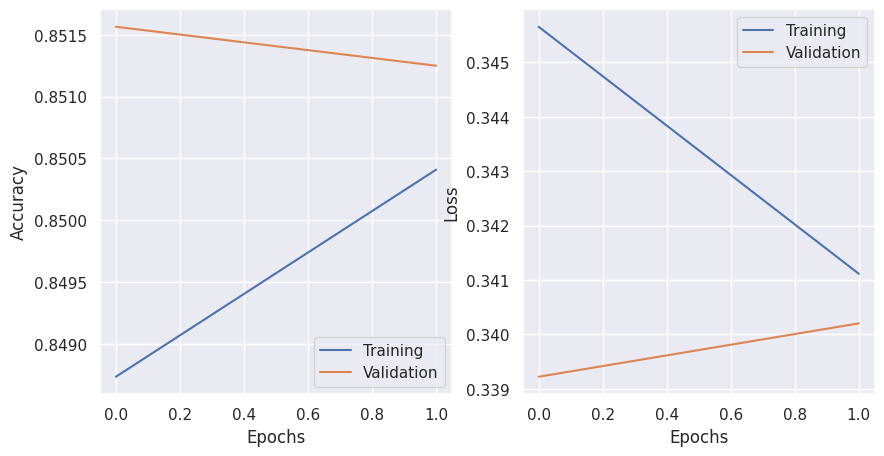

ROC curves for the best classifiers:


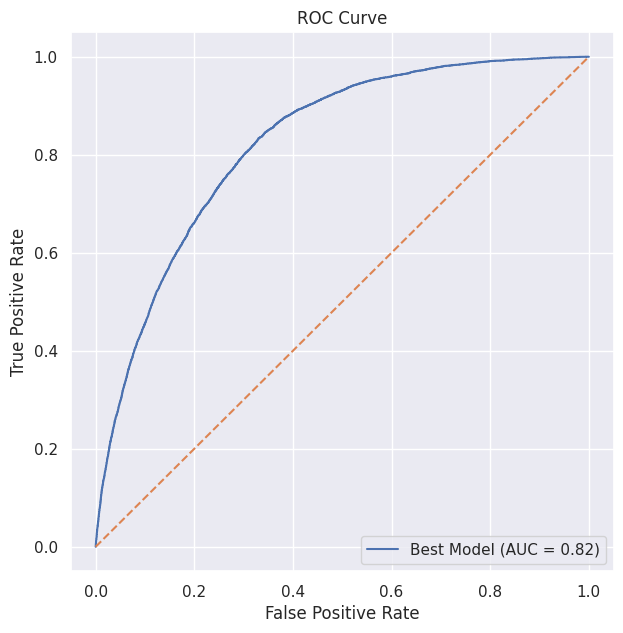

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

def plot_learning_curves(history):
    sns.set()
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

def plot_roc_curves(y_test, y_pred, title):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.figure(figsize=(7, 7))
    plt.plot(fpr, tpr, label=f"{title} (AUC = {roc_auc_score(y_test, y_pred):.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

best_layers = best_model['layers']
best_activations = best_model['activations']
best_optimizer = best_model['optimizer']

best_model, best_history = train_model(best_layers, best_activations, best_optimizer)
y_pred = best_model.predict(X_test)

print("Learning curves for the best neural network architecture:")
plot_learning_curves(best_history)

print("ROC curves for the best classifiers:")
plot_roc_curves(y_test, y_pred, "Best Model")